In [129]:
%matplotlib inline
import numpy as np
import pandas as pa
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob, os
import matplotlib.style as style 
#style.available
plt.style.use('seaborn') 
#style.use('seaborn-poster') #sets the size of the charts
import pprint
from IPython.display import HTML

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2),
              (4,2,2,1)]

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [130]:
#Clean up result directory first
results_path = 'timing_results/*'
r = glob.glob(results_path)
for i in r:
    os.remove(i)

#Then clean the plan directory
plans_path = 'query_plans/*'
r = glob.glob(plans_path)
for i in r:
    os.remove(i)
    
#Then clean the timing_results directory
timing_histogram_path = 'hist_timing_results/*'
r = glob.glob(timing_histogram_path)
for i in r:
    os.remove(i)
    
#Setup variables
result_list = []
histogram_timing_results_list = []
query_plan_list = []
i = -1

# Format the .result files from our mtr run so that we can import them using pandas csv importer

In [131]:
with open("/home/svestrhe/Documents/Forprosjekt/code/mysql-server/mysql-test/suite/histogram_plugin/r/execute_timing_local.result") as openfileobject:
    for line in openfileobject:
        if not "#" in line[:5]:
            if "Query" in line:
                i+=1
                result_list.append([line]) 
                query_plan_list.append([])
            if "Analyse statement" in line[:17]:
                histogram_timing_results_list.append([line])
            if "select" in line[:8]:
                result_list[i].append(line)
            if "EXPLAIN" in line[:7] or "->" in line or "id" in line[:4] or "1" in line[:2]:
                query_plan_list[i].append(line)
            if "explain" in line[:7]:
                query_plan_list[i].append("\n")
                query_plan_list[i].append(line)
            if "analyze table measurement" in line.lower():
                histogram_timing_results_list[i].append(line)
    i = -1   #Cleanup


In [132]:
#Export the timing results for queries
array_result = np.array(result_list)
result_list=[]      #Cleanup so that we can run the cells again and again without having to restart our kernel. 
counter = 0
for result in array_result:
    string="timing_results/{}.csv".format(counter)
    f = open(string,"w+")
    for line in result:
        f.write(line)
    f.close()
    counter+=1

    
#Export the timing results for histograms
array_hist_result = np.array(histogram_timing_results_list)
histogram_timing_results_list = []
counter = 0
for hist_result in array_hist_result:
    string="hist_timing_results/{}.csv".format(counter)
    f = open(string,"w+")
    for line in hist_result:
        f.write(line)
    f.close()
    counter+=1

# Now let's import the csv files into a dataframe. 

In [133]:
result_files = sorted(glob.glob(results_path),key=lambda x: int(x.split('.')[0][15:]))
frames = []
helper = []
counter = 0
for file in result_files:
    temp_df = pa.read_csv(str(file),'\t')
    helper.append([temp_df.iloc[0]['Test type'],counter])
    frames.append(temp_df)
    counter+=1

result_df = pa.concat(frames,sort=False)



hist_result_files = sorted(glob.glob(timing_histogram_path),key=lambda x: int(x.split('.')[0][20:]))
frames = []
counter = 0
for file in hist_result_files:
    temp_df = pa.read_csv(str(file),'\t')
 #   helper.append([temp_df.iloc[0]['Test type'],counter])
    frames.append(temp_df)
    counter+=1

hist_result_df = pa.concat(frames,sort=False)
hist_result_df=hist_result_df.astype({'No_of_executes': 'int32'})


In [134]:

#Export the query_plans
array_query_plan = np.array(query_plan_list)
query_plan_list=[]
counter = 0
for plan_set in array_query_plan:
    string="query_plans/plan_{}_{}.txt".format(counter,helper[counter][0].strip())
    f = open(string,"w+")
    for plan in plan_set:
        f.write(plan)
    f.close()
    counter+=1

In [135]:
#Create the sensitivity DF
sensitivity_df = result_df.groupby(['Test type','Supplied parameters']).sum().reset_index()
sensitivity_df = sensitivity_df[['Test type','Supplied parameters','Duration']]
sensitivity_df = sensitivity_df.rename(columns={"Duration": "Query execution duration"})
sensitivity_df_hist_data = hist_result_df.groupby(['Test type','Supplied parameters']).sum().reset_index().rename(columns={"Duration": "Histogram execution duration"})
temp = pa.merge(sensitivity_df,sensitivity_df_hist_data,how='outer',on=['Test type','Supplied parameters'])
temp = temp.fillna(0)
temp['Query and histogram execution duration'] = temp['Query execution duration'] + temp['Histogram execution duration']
df_5 = temp
temp = temp.drop(columns = ['Histogram execution duration'])
temp = temp.set_index(['Test type','Supplied parameters'])
sensitivity_df = pa.DataFrame(temp,index = temp.index).stack()
#new_df = new_df.columns(['Test type'])
sensitivity_df = sensitivity_df.to_frame()
sensitivity_df =sensitivity_df.reset_index()
sensitivity_df.columns = ['Test type','Supplied parameters','Duration type','Duration']

#Splitting the params for the base classes test types
temp_data_df = sensitivity_df.loc[sensitivity_df['Test type'].isin(['No histogram ','Perfect histogram ','Stale histogram '])]
temp_data_df = temp_data_df[~temp_data_df['Duration type'].isin(['No_of_executes'])]
base_classes_data = temp_data_df[temp_data_df['Duration type'].isin(['Query and histogram execution duration'])].groupby(['Test type']).mean().reset_index()
base_classes_data['Duration type'] = 'Query and histogram execution duration'
base_classes_data['Supplied parameters']= 'Not applicable'
temp_data_df = temp_data_df.set_index(['Test type','Duration type','Duration'])
temp_data_df = pa.DataFrame(temp_data_df['Supplied parameters'].str.split(' ').tolist(),index = temp_data_df.index).stack()
temp_data_df = temp_data_df.to_frame()
temp_data_df = temp_data_df.reset_index()
temp_data_df = temp_data_df.drop(columns='level_3')
temp_data_df.columns=['Test type','Duration type','Duration','Supplied parameters']
sensitivity_df = sensitivity_df.loc[~sensitivity_df['Test type'].isin(['No histogram ','Perfect histogram ','Stale histogram '])]
sensitivity_df = sensitivity_df.append(temp_data_df, ignore_index=True,sort=False)
sensitivity_df = sensitivity_df.append(base_classes_data, ignore_index=True,sort=False)

#Before we remove some rows, let's save this to another df
full_sensitivity_df = sensitivity_df

#Removing the query and histogram execution duration for the base classes since we don't want that to show up in our plots. 
temp_3 = sensitivity_df
temp_3 = temp_3.loc[temp_3['Test type'].isin(['No histogram ','Perfect histogram ','Stale histogram ']) & temp_3['Duration type'].isin(['Query execution duration'])]
temp_4 = pa.merge(sensitivity_df,temp_3, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
sensitivity_df = temp_4

In [149]:
sensitivity_df.set_index('Test type').loc[['Plugin rule 2']]

,Supplied parameters,Duration type,Duration
Test type,,,
Plugin rule 2,10000,Query execution duration,433.896868
Plugin rule 2,10000,No_of_executes,390.000000
Plugin rule 2,10000,Query and histogram execution duration,500.299323
Plugin rule 2,50000,Query execution duration,272.809195
Plugin rule 2,50000,No_of_executes,78.000000
Plugin rule 2,50000,Query and histogram execution duration,279.350319
Plugin rule 2,100000,Query execution duration,268.511827
Plugin rule 2,100000,No_of_executes,39.000000
Plugin rule 2,100000,Query and histogram execution duration,271.786368


# Format the queries to be q1 q2 etc. add a result_ratio column and a formatted query column

In [137]:
i=1
replace_dictionary = {}
unique_queries = result_df.Query.unique().tolist()
for query in unique_queries:
    name = 'q{}'.format(i)
    replace_dictionary[query]=name
    i+=1

result_df['Short_Query']=result_df['Query'].replace(replace_dictionary)

partition_size = min(result_df["Number of Inserts"].unique().tolist())
result_df['Result_ratio']=result_df['Returned rows']/partition_size

queries = result_df['Query'].tolist()
short_query_format=[]
for query in queries:
    no_of_joins = query.count('join')
    where_predicate_value = query.split("test.measurement.msm_value",1)[1]
    short_query_format.append('Query with '+str(no_of_joins)+' joins and WHERE MSM_VALUE' +where_predicate_value)
result_df['Short_query_format']=short_query_format




In [138]:
unformatted_plan_files = glob.glob(plans_path)
for file in unformatted_plan_files:
    output_file_name=file+".tmp"
    with open(file, 'r') as f, open(output_file_name, 'w+') as fo:
        for line in f:
            formatted_line = line.replace('explain format = tree ', '').replace(";","") 
           # print(formatted_line) 
            for query,key in replace_dictionary.items():
                if query==formatted_line:
                    fo.write(key)
                    break
            fo.write(line)
    os.remove(file)

## Prelim-results, don't run unless running prelim tests

In [ ]:
#ax=sns.lineplot(x="Number of Inserts", y="Duration",
#            hue="Test type", markers=True,
#            data=result_df[result_df.Short_Query.isin(['q2'])])
#q2_prelim_line_plot = plt.gcf()
#q2_prelim_line_plot.savefig("/export/home/tmp/Dropbox/Apper/ShareLaTeX/Master/plots/prelim/q2_prelim_line_plot.png",dpi=360)
#plt.show()

## Standard results

/home/svestrhe/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/home/svestrhe/.local/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

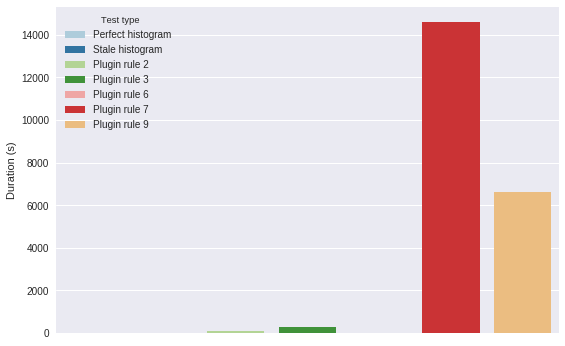

In [27]:
base_rules = ['No histogram ','Perfect histogram ','Stale histogram ']
for rule in result_df['Test type'].unique().tolist():
    if rule not in base_rules:
        base_rules.append(rule)
        temp = result_df.set_index('Test type')
        temp = temp.loc[base_rules]
        temp = temp.reset_index()
        for query in temp.Short_Query.unique().tolist():
            fig = plt.figure(figsize=(13,9))
            gs = gridspec.GridSpec(nrows=4, 
                                   ncols=1, 
                                   figure=fig, 
                                   height_ratios=[1, 1, 1, 1],
                                   wspace=0.3,
                                   hspace=0.3)

            ax1 = fig.add_subplot(gs[1:3,0])
            sns.lineplot(x="Number of Inserts", y="Duration",
                         hue="Test type", style="Test type",markers = True,dashes = True,
                         data=temp[temp.Short_Query.isin([query])],ax=ax1)
            xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax1.get_xticks()/1000]
            ax1.set_xticklabels(xlabels)
            ax1.set_xlabel("Number of updates")
            ax1.set_ylabel("Duration (s)")
           # ax1.set_title(str(result_df['Short_query_format'][result_df.Short_Query.isin([query])].iloc[0]))

            ax2 = fig.add_subplot(gs[0, 0])

            all_hist = result_df[result_df["Test type"].str.contains('Perfect histogram')]
            index_position = all_hist[all_hist.Short_Query.isin([query])].index[0]
            final = all_hist[all_hist.Short_Query.isin([query])].loc[index_position]
            sns.barplot(x="Number of Inserts", y="Result_ratio",data=final ,ax=ax2, color=sns.xkcd_rgb["denim blue"])


            ax2.spines['right'].set_visible(False)
            ax2.spines['top'].set_visible(False)
            #ax2.xaxis.set_major_locator(ax1.xaxis.get_major_locator())
            #ax2.set_xticklabels(ax1.get_xticklabels())
            ax2.set_xticklabels("")
            ax2.margins(x=ax1.margins()[0]-0.01)
            ax2.set_xlabel("")
            ax2.set_ylabel("Result size ratio")
          #  ax2.set_title(str(result_df['Short_query_format'][result_df.Short_Query.isin([query])].iloc[0]))

            #fig.suptitle(str(result_df['Short_query_format'][result_df.Short_Query.isin([query])].iloc[0]),y=0.9)

            line_plot = plt.gcf()
            path = "/export/home/tmp/Dropbox/Apper/ShareLaTeX/Master/eval_plots/line_plots/all_q_plots/"
            name = str(temp['Short_query_format'][temp.Short_Query.isin([query])].iloc[0])+str(base_rules)+".png"
            line_plot.savefig(path+name,dpi=360,bbox_inches='tight')
            plt.clf()
        base_rules.pop()
    if rule == 'No histogram ':
        temp = result_df.set_index('Test type')
        temp = temp.loc[base_rules]
        temp = temp.reset_index()
        for query in temp.Short_Query.unique().tolist():
            fig = plt.figure(figsize=(13,9))
            gs = gridspec.GridSpec(nrows=4, 
                                   ncols=1, 
                                   figure=fig, 
                                   height_ratios=[1, 1, 1, 1],
                                   wspace=0.3,
                                   hspace=0.3)

            ax1 = fig.add_subplot(gs[1:3,0])
            sns.lineplot(x="Number of Inserts", y="Duration",
                         hue="Test type", style="Test type",markers = True,dashes = True,
                         data=temp[temp.Short_Query.isin([query])],ax=ax1)
            xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax1.get_xticks()/1000]
            ax1.set_xticklabels(xlabels)
            ax1.set_xlabel("Number of updates")
            ax1.set_ylabel("Duration (s)")
           # ax1.set_title(str(result_df['Short_query_format'][result_df.Short_Query.isin([query])].iloc[0]))

            ax2 = fig.add_subplot(gs[0, 0])

            all_hist = result_df[result_df["Test type"].str.contains('Perfect histogram')]
            index_position = all_hist[all_hist.Short_Query.isin([query])].index[0]
            final = all_hist[all_hist.Short_Query.isin([query])].loc[index_position]
            sns.barplot(x="Number of Inserts", y="Result_ratio",data=final ,ax=ax2, color=sns.xkcd_rgb["denim blue"])


            ax2.spines['right'].set_visible(False)
            ax2.spines['top'].set_visible(False)
            #ax2.xaxis.set_major_locator(ax1.xaxis.get_major_locator())
            #ax2.set_xticklabels(ax1.get_xticklabels())
            ax2.set_xticklabels("")
            ax2.margins(x=ax1.margins()[0]-0.01)
            ax2.set_xlabel("")
            ax2.set_ylabel("Result size ratio")
          #  ax2.set_title(str(result_df['Short_query_format'][result_df.Short_Query.isin([query])].iloc[0]))

            #fig.suptitle(str(result_df['Short_query_format'][result_df.Short_Query.isin([query])].iloc[0]),y=0.9)

            line_plot = plt.gcf()
            path = "/export/home/tmp/Dropbox/Apper/ShareLaTeX/Master/eval_plots/lin~e_plots/all_q_plots/"
            name = str(temp['Short_query_format'][temp.Short_Query.isin([query])].iloc[0])+str(base_rules)+".png"
            line_plot.savefig(path+name,dpi=360,bbox_inches='tight')
            plt.clf()
    
fig = plt.figure(figsize=(9,6))
ax3=sns.barplot(x="Test type", y="Duration",hue="Test type", data=hist_result_df, estimator=sum,ci=None,dodge = False,palette = sns.color_palette("Paired", 9))
ax3.set_xticklabels("")
ax3.set_xlabel("")
ax3.set_ylabel("Duration (s)")
hist_timing_plt = plt.gcf()
hist_timing_plt.savefig("/export/home/tmp/Dropbox/Apper/ShareLaTeX/Master/eval_plots/histogram_timing.png",dpi=360,bbox_inches='tight')

# One off plots#

In [ ]:
query = 'q4'
rules = ['No histogram ','Perfect histogram ','Stale histogram ']
fig = plt.figure(figsize=(13,9))
gs = gridspec.GridSpec(nrows=4, 
                       ncols=1, 
                       figure=fig, 
                       height_ratios=[1, 1, 1, 1],
                       wspace=0.3,
                       hspace=0.3)

ax1 = fig.add_subplot(gs[1:3,0])
sns.lineplot(x="Number of Inserts", y="Duration",
             hue="Test type", style="Test type", markers=True,ci=99,
             data=result_df[result_df.Short_Query.isin([query])& result_df['Test type'].isin(rules)],ax=ax1)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax1.get_xticks()/1000]
ax1.set_xticklabels(xlabels)
ax1.set_xlabel("Number of updates")
ax1.set_ylabel("Duration (s)")
# ax1.set_title(str(result_df['Short_query_format'][result_df.Short_Query.isin([query])].iloc[0]))

ax2 = fig.add_subplot(gs[0, 0])

all_hist = result_df[result_df["Test type"].str.contains('Perfect histogram')]
index_position = all_hist[all_hist.Short_Query.isin([query])].index[0]
final = all_hist[all_hist.Short_Query.isin([query])].loc[index_position]
sns.barplot(x="Number of Inserts", y="Result_ratio",data=final ,ax=ax2, color=sns.xkcd_rgb["denim blue"])


ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.xaxis.set_major_locator(ax1.xaxis.get_major_locator())
#ax2.set_xticklabels(ax1.get_xticklabels())
ax2.set_xticklabels("")
ax2.margins(x=ax1.margins()[0]-0.01)
ax2.set_xlabel("")
ax2.set_ylabel("Result size ratio")
#  ax2.set_title(str(result_df['Short_query_format'][result_df.Short_Query.isin([query])].iloc[0]))

#fig.suptitle(str(result_df['Short_query_format'][result_df.Short_Query.isin([query])].iloc[0]),y=0.9)

line_plot = plt.gcf()

path = "/export/home/tmp/Dropbox/Apper/ShareLaTeX/Master/eval_plots/line_plots/"
name = str(result_df['Short_query_format'][result_df.Short_Query.isin([query])].iloc[0])+str(rules)+".png"
line_plot.savefig(path+name,dpi=360,bbox_inches='tight')
plt.clf()

# Generate Q-ratio data#

In [139]:
q_ratio_df=df_5.loc[df_5['Test type'].isin(['No histogram ','Perfect histogram ','Stale histogram '])].groupby(['Test type']).mean().reset_index()
q_ratio_df['Supplied parameters'] = 'Not applicable'
q_ratio_df = q_ratio_df.append(df_5.loc[~df_5['Test type'].isin(['No histogram ','Perfect histogram ','Stale histogram '])],ignore_index=True,sort=False)
q_ratio_df = q_ratio_df[['Test type','Query execution duration','Histogram execution duration','No_of_executes','Query and histogram execution duration','Supplied parameters']]
q_ratio_df=q_ratio_df.rename(columns={"Query and histogram execution duration": "Total duration", "No_of_executes": "Number of histogram udpates/creates"})
q_ratio_df['Q-ratio']=q_ratio_df['Total duration'].apply(lambda x: x/q_ratio_df['Total duration'].loc[q_ratio_df['Test type']=='Perfect histogram '], 0)
q_ratio_df = q_ratio_df.sort_values('Q-ratio')
q_ratio_df.head(5000)

,Test type,Query execution duration,Histogram execution duration,Number of histogram udpates/creates,Total duration,Supplied parameters,Q-ratio
16,Plugin rule 6,267.094430,3.307501,55.0,270.401931,0.1,0.982155
9,Plugin rule 2,268.511827,3.274541,39.0,271.786368,100000,0.987183
14,Plugin rule 3,268.953461,3.280519,39.0,272.233980,500000,0.988809
18,Plugin rule 6,270.260807,3.306000,55.0,273.566807,0.9,0.993650
26,Plugin rule 9,272.323269,1.595539,19.0,273.918808,0.90 0.2 500000,0.994929
17,Plugin rule 6,271.513497,3.312466,55.0,274.825963,0.5,0.998224
1,Perfect histogram,273.589126,1.725912,20.0,275.315038,Not applicable,1.000000
8,Plugin rule 2,272.809195,6.541124,78.0,279.350319,50000,1.014657
25,Plugin rule 9,268.891475,11.199573,134.0,280.091048,0.5 2 100000,1.017347
15,Plugin rule 6,280.163513,3.480615,55.0,283.644128,0.05,1.030253


In [140]:
df_5.head(500)

,Test type,Supplied parameters,Query execution duration,Histogram execution duration,No_of_executes,Query and histogram execution duration
0,No histogram,10000 0.05 200 5000,407.357792,0.000000,0.0,407.357792
1,No histogram,100000 0.5 2 100000,296.996209,0.000000,0.0,296.996209
2,No histogram,50000 0.1 20 50000,300.949789,0.000000,0.0,300.949789
3,No histogram,500000 0.90 0.2 500000,298.755136,0.000000,0.0,298.755136
4,Perfect histogram,10000 0.05 200 5000,283.617019,1.809026,20.0,285.426045
5,Perfect histogram,100000 0.5 2 100000,268.158574,1.704012,20.0,269.862586
6,Perfect histogram,50000 0.1 20 50000,269.488339,1.693265,20.0,271.181604
7,Perfect histogram,500000 0.90 0.2 500000,273.092573,1.697343,20.0,274.789916
8,Plugin rule 0,10000 0.05,734.782938,0.000000,0.0,734.782938
9,Plugin rule 0,100000 0.5,297.061350,0.000000,0.0,297.061350


# Generate sensitivity plots for single parameter rules#

In [156]:
base_rules = ['No histogram ','Perfect histogram ','Stale histogram ']
rules_to_avoid_for_now = ['Plugin rule 9','Plugin rule 0','Plugin rule 7','Plugin rule 3']
for rule in sensitivity_df['Test type'].unique().tolist():
   # if rule == 'No histogram ':
   #     temp = sensitivity_df.set_index('Test type')
   #     temp = temp.loc[base_rules].reset_index().set_index('Supplied parameters').loc['Not applicable'].reset_index()
   #     fig = plt.figure(figsize=(13,9))
   #     gs = gridspec.GridSpec(nrows=4, 
   #                        ncols=1, 
   #                        figure=fig, 
   #                        height_ratios=[1, 1, 1, 1],
   #                        wspace=0.3,
   #                        hspace=0.3)
   #     ax1 = fig.add_subplot(gs[1:3,0])
  #      sns.lineplot(x="Supplied parameters", y="Duration",
  #                   markers=True, hue = 'Test type', style = 'Duration type',
  #                   data=temp[~temp['Duration type'].isin(['No_of_executes'])],ax=ax1)
  #      xlabels = [float(x) for x in ax1.get_xticks()]
  #      ax1.set_xticklabels(xlabels)
  #      ax1.set_ylabel("Duration (s)")
  #      sensitivity_plot = plt.gcf()
  #      path = "/export/home/tmp/Dropbox/Apper/ShareLaTeX/Master/eval_plots/sensitivity_plots/"
 #       name = str(base_rules)+".png"
 #       sensitivity_plot.savefig(path+name,dpi=360,bbox_inches='tight')
#        plt.clf()
    if rule not in base_rules and rule not in rules_to_avoid_for_now:
        base_rules.append(rule)
        temp = sensitivity_df.set_index('Test type')
        temp = temp.loc[base_rules]
        temp = temp[~temp['Supplied parameters'].isin(['Not applicable'])]
        temp=temp.astype({'Supplied parameters': 'float'})
        holder = temp.groupby('Test type')
        holder = holder.apply(lambda x: x['Supplied parameters'].unique())
        unique_params_we_want_to_use = holder.loc[rule].tolist()
        temp = temp.loc[temp['Supplied parameters'].isin(unique_params_we_want_to_use)].reset_index()
        fig = plt.figure(figsize=(13,9))
        gs = gridspec.GridSpec(nrows=4, 
                           ncols=1, 
                           figure=fig, 
                           height_ratios=[1, 1, 1, 1],
                           wspace=0.3,
                           hspace=0.3)
        ax1 = fig.add_subplot(gs[1:3,0])
        sns.lineplot(x="Supplied parameters", y="Duration",
                     markers=True, hue = 'Test type', style = 'Duration type',
                     data=temp[~temp['Duration type'].isin(['No_of_executes'])],ax=ax1)
        ax1.set_ylabel("Duration (s)")
        sensitivity_plot = plt.gcf()
        path = "/export/home/tmp/Dropbox/Apper/ShareLaTeX/Master/eval_plots/sensitivity_plots/"
        name = str(base_rules)+".png"
        sensitivity_plot.savefig(path+name,dpi=360,bbox_inches='tight')
        plt.clf()
        base_rules.pop()

<Figure size 936x648 with 0 Axes>

<Figure size 936x648 with 0 Axes>

In [155]:
temp = sensitivity_df.set_index('Test type')
temp = temp.loc[['No histogram ','Perfect histogram ','Stale histogram ','Plugin rule 2']]
temp = temp[~temp['Supplied parameters'].isin(['Not applicable'])]
temp=temp.astype({'Supplied parameters': 'float'})
holder = temp.groupby('Test type')
holder = holder.apply(lambda x: x['Supplied parameters'].unique())
unique_params_we_want_to_use = holder.loc[rule].tolist()
temp = temp.loc[temp['Supplied parameters'].isin(unique_params_we_want_to_use)].reset_index()
temp.head(500)

,Test type,Supplied parameters,Duration type,Duration
0,No histogram,10000.0,Query and histogram execution duration,407.357792
1,No histogram,100000.0,Query and histogram execution duration,296.996209
2,No histogram,100000.0,Query and histogram execution duration,296.996209
3,No histogram,50000.0,Query and histogram execution duration,300.949789
4,No histogram,50000.0,Query and histogram execution duration,300.949789
5,No histogram,500000.0,Query and histogram execution duration,298.755136
6,No histogram,500000.0,Query and histogram execution duration,298.755136
7,Perfect histogram,10000.0,Query and histogram execution duration,285.426045
8,Perfect histogram,100000.0,Query and histogram execution duration,269.862586
9,Perfect histogram,100000.0,Query and histogram execution duration,269.862586


# Average q-ratio, må kanskje endre slik at vi lager en q-ratio for hvert sett med parameter verdier , Ser ut som at denne kanskje er litt feil, se på q-ratio...#

In [ ]:
q_ratio_df = result_df.groupby(['Test type','Supplied parameters']).sum().reset_index()
q_ratio_df = q_ratio_df[['Test type','Duration','Supplied parameters']]
q_ratio_df = q_ratio_df.groupby(['Test type']).mean().reset_index()
q_ratio_df['Q-ratio']=q_ratio_df['Duration'].apply(lambda x: x/q_ratio_df['Duration'].loc[q_ratio_df['Test type']=='Perfect histogram '], 0)
q_ratio_df = q_ratio_df.sort_values('Q-ratio')
#q_ratio_df.head(100)

hist_result_df=hist_result_df.astype({'No_of_executes': 'int32'})
histogram_data = hist_result_df.groupby(['Test type','Supplied parameters'])['Duration','No_of_executes'].sum().reset_index()
histogram_data = histogram_data.groupby(['Test type']).mean().reset_index()
histogram_data=histogram_data.rename(columns={"Duration": "Time spent computing histograms (s)", "No_of_executes": "Number of histogram udpates/creates"})
#histogram_data.head(50)

merged_df = q_ratio_df.merge(histogram_data, how = 'outer', on = ['Test type'])
merged_df = merged_df.fillna(0)
merged_df = merged_df.astype({'Number of histogram udpates/creates':'int32'})
merged_df.head(50)

In [145]:
#neste forsøk på Q-ratio
q_ratio_df=df_5.loc[df_5['Test type'].isin(['No histogram ','Perfect histogram ','Stale histogram '])].groupby(['Test type']).mean().reset_index()
q_ratio_df['Supplied parameters'] = 'Not applicable'
q_ratio_df = q_ratio_df.append(df_5.loc[~df_5['Test type'].isin(['No histogram ','Perfect histogram ','Stale histogram '])],ignore_index=True,sort=False)
q_ratio_df = q_ratio_df[['Test type','Query execution duration','Histogram execution duration','No_of_executes','Query and histogram execution duration','Supplied parameters']]
q_ratio_df=q_ratio_df.rename(columns={"Query and histogram execution duration": "Total duration", "No_of_executes": "Number of histogram udpates/creates"})
q_ratio_df['Q-ratio']=q_ratio_df['Total duration'].apply(lambda x: x/q_ratio_df['Total duration'].loc[q_ratio_df['Test type']=='Perfect histogram '], 0)
q_ratio_df = q_ratio_df.sort_values('Q-ratio')
q_ratio_df.head(500)

,Test type,Query execution duration,Histogram execution duration,Number of histogram udpates/creates,Total duration,Supplied parameters,Q-ratio
16,Plugin rule 6,267.094430,3.307501,55.0,270.401931,0.1,0.982155
9,Plugin rule 2,268.511827,3.274541,39.0,271.786368,100000,0.987183
14,Plugin rule 3,268.953461,3.280519,39.0,272.233980,500000,0.988809
18,Plugin rule 6,270.260807,3.306000,55.0,273.566807,0.9,0.993650
26,Plugin rule 9,272.323269,1.595539,19.0,273.918808,0.90 0.2 500000,0.994929
17,Plugin rule 6,271.513497,3.312466,55.0,274.825963,0.5,0.998224
1,Perfect histogram,273.589126,1.725912,20.0,275.315038,Not applicable,1.000000
8,Plugin rule 2,272.809195,6.541124,78.0,279.350319,50000,1.014657
25,Plugin rule 9,268.891475,11.199573,134.0,280.091048,0.5 2 100000,1.017347
15,Plugin rule 6,280.163513,3.480615,55.0,283.644128,0.05,1.030253


In [47]:
sensitivity_df.head(500)#df_5.head(500)
sensitivity_df[sensitivity_df['Duration type'].isin(['No_of_executes'])]

,Test type,Supplied parameters,Duration type,Duration
0,Plugin rule 0,10000 0.05,Query execution duration,734.782938
2,Plugin rule 0,10000 0.05,Query and histogram execution duration,734.782938
3,Plugin rule 0,100000 0.5,Query execution duration,297.061350
5,Plugin rule 0,100000 0.5,Query and histogram execution duration,297.061350
6,Plugin rule 0,50000 0.1,Query execution duration,297.802500
...,...,...,...,...
209,Stale histogram,20,Query execution duration,321.437508
220,Stale histogram,500000,Query execution duration,320.157960
221,Stale histogram,500000,Query execution duration,320.157960
222,Stale histogram,0.90,Query execution duration,320.157960


In [ ]:
##Working og gettign the data we want to create our standard query execution times plots for
xlabels = ['{:,.4f}'.format(float(re.sub("\D", "", str(x)))) for x in  ['r=0.1','r=0.2','r=0.4']]
a = [re.sub("\d", "", x) for x in ['r=0.1','r=0.2','r=0.4']]
print (xlabels)
print(ax1.get_xticklabels())

In [ ]:
x='aaa12333bb445bb54b5b52'
import re
re.sub("\D", "", "aas30dsa20")

In [ ]:
df_1 = sensitivity_df.loc[sensitivity_df['Test type'].isin(['Plugin rule 9'])]

df_1 = df_1.append([df_1]*2,ignore_index=True)
df_1.at[0,'Supplied parameters'] = 'bw=2 I=50000'
df_1.at[1,'Supplied parameters'] = 'bw=2 I=50000'
df_1.at[2,'Supplied parameters'] = 'bw=200000 I=5'
df_1.at[3,'Supplied parameters'] = 'bw=200000 I=5'
df_1.at[4,'Supplied parameters'] = 'bw=20 I=50000'
df_1.at[5,'Supplied parameters'] = 'bw=20 I=50000'
df_1.at[6,'Supplied parameters'] = 'bw=200000 I=500'
df_1.at[7,'Supplied parameters'] = 'bw=200000 I=500'
df_1.at[8,'Supplied parameters'] = 'bw=200000 I=50'
df_1.at[9,'Supplied parameters'] = 'bw=200000 I=50'
df_1.at[10,'Supplied parameters'] = 'bw=200000 I=5'
df_1.at[11,'Supplied parameters'] = 'bw=200000 I=5'
df_1=df_1.set_index(['Test type','Duration type','Duration'])

df_2 = pa.DataFrame(df_1['Supplied parameters'].str.split(' ',1).tolist(),index = df_1.index,columns=['param_1','param_2'])
df_1 = df_1.reset_index()
df_2=df_2.reset_index()
data_for_now = df_2.groupby(['param_1'])
data_for_now.head(500)

In [ ]:
fig = plt.figure(figsize=(13,9))
gs = gridspec.GridSpec(nrows=4, 
                   ncols=1, 
                   figure=fig, 
                   height_ratios=[1, 1, 1, 1],
                   wspace=0.3,
                   hspace=0.3)
ax1 = fig.add_subplot(gs[1:3,0])
sns.lineplot(x="param_1", y="Duration",
             markers=True, hue = 'param_2', style = 'Duration type',
             data=df_2,ax=ax1)
ax1.set_ylabel("Duration (s)")
#xlabels = ['{:,.4f}'.format(float(re.sub("\D", "", str(x)))) for x in ax1.get_xticks()]
#ax1.set_xticklabels(xlabels)
ax1.set_xlabel("Outside boundary weight parameter")

fig = plt.figure(figsize=(13,9))
gs = gridspec.GridSpec(nrows=4, 
                   ncols=1, 
                   figure=fig, 
                   height_ratios=[1, 1, 1, 1],
                   wspace=0.3,
                   hspace=0.3)
ax1 = fig.add_subplot(gs[1:3,0])
sns.lineplot(x="Supplied parameters", y="Duration",
             markers=True, hue = 'Test type', style = 'Duration type',
             data=df_1,ax=ax1)
ax1.set_ylabel("Duration (s)")
#xlabels = ['{:,.4f}'.format(float(re.sub("\D", "", str(x)))) for x in ax1.get_xticks()]
#ax1.set_xticklabels(xlabels)
ax1.set_xlabel("Supplied parameters")

In [ ]:
fig = plt.figure(figsize=(9,6))
ax3=sns.barplot(x="Test type", y="Duration",hue="Test type", data=hist_result_df[hist_result_df['Test type'].isin(['No histogram ','Perfect histogram ','Stale histogram '])], estimator=sum,ci=None,dodge = False )#,color=sns.xkcd_rgb["orange"])
ax3.set_xticklabels("")
ax3.set_xlabel("")
ax3.set_ylabel("Duration (s)")
hist_timing_plt = plt.gcf()
hist_timing_plt.savefig("/export/home/tmp/Dropbox/Apper/ShareLaTeX/Master/eval_plots/histogram_timing_base.png",dpi=360,bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(9,6))
ax3=sns.barplot(x="Test type", y="Duration",hue="Test type", data=hist_result_df, estimator=sum,ci=None,dodge = False )#,color=sns.xkcd_rgb["orange"])
ax3.set_xticklabels("")
ax3.set_xlabel("")
ax3.set_ylabel("Duration (s)")

In [ ]:
sns.palplot(sns.color_palette("Paired", 9))

In [ ]:
new_map = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999']
sns.palplot(sns.color_palette(new_map))

In [ ]:
d = {'Fixed data without Histograms': result_0_df, 'Fixed data with Histograms': result_1_df}
temp=pa.concat(d,axis=1)
temp=temp.transpose().drop(index='Average',level=1)
temp = temp.drop(index='Returned rows',level=1)
#temp = temp.drop(index='Query',level=1)
temp2=pa.concat([result_0_df,result_1_df],join='inner',axis=1)
temp2=temp2.drop(columns='Average')

In [ ]:
1002%1000

In [ ]:
temp

In [ ]:
temp.unstack(level=0)

In [ ]:
temp.unstack(level=0).transpose()

In [ ]:
plt.errorbar(temp.unstack(level=0)[8].transpose()['Adjusted average'],temp.unstack(level=0)[8].transpose()['Standard Deviation'])

In [ ]:
plt.errorbar([1,2,3,4,5,6,7],[1,2,3,4,5,6,7],yerr=2)

In [ ]:
midx = pa.MultiIndex(levels=[['zero', 'one'], ['x', 'y']],
   ....:                      codes=[[1, 1, 0, 0], [1, 0, 1, 0]])
df = pa.DataFrame(np.random.randn(4, 2), index=midx)

In [ ]:
df.transpose()

In [ ]:
df.transpose().plot.box()

In [ ]:
midx = pa.MultiIndex(levels=[['without_histogram', 'with_histogram'], ['q1', 'q2', 'q3']],
   ....:                      codes=[[1, 1, 0, 0], [1, 0, 1, 0]])
df = pa.DataFrame(np.random.randn(4, 4), index=midx)

In [ ]:
df

In [ ]:

iterables = [['without_histogram','with_histogram'], ['q1', 'q2','q3'],['r1','r2','r3','r4','r5','r6','r7','r8']]

mindex=pa.MultiIndex.from_product(iterables, names=['Test type', 'Query','Run#'])
df = pa.DataFrame(np.random.randn(48), index=mindex)
df

In [ ]:
df.unstack(level=1).plot.box()

In [ ]:
df.unstack(level=1)

In [ ]:
series=result_0_df.drop(columns=['Average','Standard Deviation','Returned rows','Query'])
series.set_index('Adjusted average')
series.dtypes

result=pa.DataFrame(result_tot_df['Adjusted average'].values, index=mindex)

In [ ]:
result

In [ ]:
result.unstack(level=[0,1]).boxplot()

In [ ]:
result.unstack(level=[1])

In [ ]:
result

In [ ]:
df = pa.DataFrame(np.random.randn(10, 2),
...                   columns=['Col1', 'Col2'])
>>> df['X'] = pa.Series(['A', 'A', 'A', 'A', 'A',
...                      'B', 'B', 'B', 'B', 'B'])
>>> boxplot = df.boxplot(by='X')

In [ ]:
df

In [ ]:
np.random.seed(45)
a = pa.DataFrame(index=range(10), 
                 columns=pa.MultiIndex.from_product(
                         iterables=[['2000', '2010'], ['a', 'b']], 
                         names=['Year', 'Text']), 
                 data=np.random.randn(10,4))

b = a.stack(level=0).reset_index(level=0, drop=True).reset_index()

In [ ]:
b

In [ ]:
b = a.unstack(level=0).reset_index(level=2, drop=True).reset_index(name='data')
b.head(15)

In [ ]:
a.head(15)

In [ ]:
ax = sns.boxplot(x='Text', y='data', hue="Year",
                 data=b, palette="Set3")

In [ ]:
result_tot_2_df